In [2]:
import json
import os
from datetime import datetime, timedelta
from typing import Optional

import numpy as np
import pandas as pd
import talib as ta
import mplfinance as mpf
from dotenv import load_dotenv
from okx.MarketData import MarketAPI
from pandas import DataFrame
from tqdm import tqdm

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'

Matplotlib is building the font cache; this may take a moment.


In [3]:
load_dotenv()
KEY = os.getenv("OKX_API_KEY")
SECRET = os.getenv("OKX_API_SECRET")
assert KEY and SECRET, "API key and secret are required"
market = MarketAPI(KEY, SECRET, flag="0", debug=False)

True

In [4]:
def to_candles(data: list) -> DataFrame:
    """将数据转换为用于绘制 K 线图的 DataFrame

    Args:
        data: JSON 数据

    Returns:
        DataFrame: 一组 K 线数据帧
    """
    df = pd.DataFrame(
        data,
        columns=[
            "ts",
            "open",
            "high",
            "low",
            "close",
            "volume",
            "volCcy",
            "volCcyQuote",
            "_",
        ],
    )
    return df

def get_current_candlestick(instId: str, bar: str = "1H") -> DataFrame:
    """获取当前 K 线数据"""
    if not isinstance(instId, str):
        raise TypeError("instId must be a string")

    # 获取最近 3 个小时级别的 K 线数据
    resp = market.get_candlesticks(instId, bar=bar, limit="2")
    data = resp["data"]
    df = to_candles(data)
    return df


def get_candlesticks(instId: str, bar: str = "1H", limit: str = "100") -> DataFrame:
    """获取 K 线数据, 包含历史数据和最新数据"""
    if not isinstance(instId, str):
        raise TypeError("instId must be a string")
    if not isinstance(instId, str):
        raise TypeError("instId must be a string")
    if not (isinstance(limit, str) and limit.isdigit()):
        raise TypeError("limit must be a number")

    dst_dir = f"./data/{instId}/{bar}"
    file_path = f"./data/{instId}/{bar}/{instId}.json"

    # 获取最新的 K 线数据
    latest_df = get_current_candlestick(instId, bar)
    # 获取历史的 K 线数据
    resp = market.get_history_candlesticks(instId, bar=bar, limit=limit)
    history_data = resp["data"]
    history_df = to_candles(history_data)
    df = merge_candlesticks(history_df, latest_df)
    data = df.to_dict(orient="records")
    os.makedirs(dst_dir, exist_ok=True)
    with open(file_path, "w") as f:
        f.write(json.dumps(data, indent=4))
    return df

# def save_candlesticks(instId: str, df: pd.DataFrame) -> None:
#     data = df.to_dict(orient="records")
#     os.makedirs("./data", exist_ok=True)
#     with open(f"./data/{instId}.json", "w") as f:
#         f.write(json.dumps(data, indent=4))

def merge_candlesticks(df1: DataFrame, df2: DataFrame) -> DataFrame:
    """合并两个 K 线数据帧

    Args:
        df1: K 线数据帧 1
        df2: K 线数据帧 2

    Returns:
        DataFrame: 合并后的 K 线数据帧
    """
    # 合并历史数据和最新数据，按时间戳去重，保留 '_' 为 1 的数据，即收盘数据
    df = pd.concat([df1, df2], ignore_index=True)
    df.drop_duplicates("ts", keep="last", inplace=True)
    df.sort_values("ts", ascending=True, inplace=True)
    return df

## 策略

需要同时满足以下条件:

1. MACD 金叉
2. KDJ 金叉
3. Boll 上穿

这三个条件在最近 n 个 K 线内同时满足.

## 交易对

In [5]:
instId = "XLM-USDT-SWAP"

In [6]:
def get_df(instId):
    df = get_candlesticks(instId)
    df = df.reset_index(drop=True)
    df["ts"] = df["ts"].astype(int)
    df["ts"] = pd.to_datetime(df["ts"], unit="ms") + timedelta(hours=8)
    dif, dea, macd = ta.MACD(df["close"], fastperiod=12, slowperiod=26, signalperiod=9)
    df["dif"] = dif
    df["dea"] = dea
    df["macd"] = macd

    kdj_k, kdj_d = ta.STOCH(
        df["high"],
        df["low"],
        df["close"],
        fastk_period=9,
        slowk_period=3,
        slowk_matype=0,
        slowd_period=3,
        slowd_matype=0,
    )
    df["kdj_k"] = kdj_k
    df["kdj_d"] = kdj_d

    upperband, middleband, lowerband = ta.BBANDS(df["close"], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df["upperband"] = upperband
    df["middleband"] = middleband
    df["lowerband"] = lowerband
    return df

In [7]:
df = get_df(instId)

In [8]:
df_plot = df.copy()
df_plot = df_plot[["ts", "high", "low", "close", "open", "volume"]]
df_plot = df_plot.rename(columns={'ts': "Date", "open": "Open", "high": "High", "low": "Low", "close": "Close", "volume": "Volume"})
df_plot.set_index('Date', inplace=True)
for column_name in ("High", "Low", "Close", "Open", "Volume"):
    df_plot[column_name] = df_plot[column_name].astype(float)
df_plot

,High,Low,Close,Open,Volume
Date,,,,,
2024-06-02 16:00:00,0.1061,0.1056,0.1060,0.1056,5690.0
2024-06-02 17:00:00,0.1060,0.1051,0.1054,0.1059,7383.0
2024-06-02 18:00:00,0.1055,0.1052,0.1055,0.1053,3348.0
2024-06-02 19:00:00,0.1060,0.1052,0.1059,0.1054,9178.0
2024-06-02 20:00:00,0.1060,0.1055,0.1056,0.1059,4301.0
...,...,...,...,...,...
2024-06-06 16:00:00,0.1064,0.1060,0.1062,0.1061,4618.0
2024-06-06 17:00:00,0.1066,0.1061,0.1063,0.1062,5882.0
2024-06-06 18:00:00,0.1063,0.1060,0.1063,0.1063,9460.0


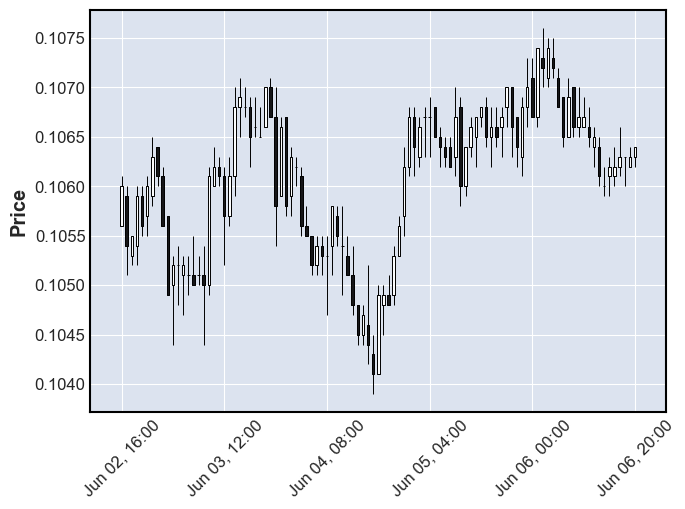

In [9]:
mpf.plot(df_plot,type='candle')

## 计算指标

macd，kdj，boll

## 计算 MACD 金叉和死叉

In [10]:
def get_macd_df(df):
    macd_df = df[["ts", "macd", "dif", "dea"]].copy()

    # 定义一个函数来确定 signal 列的值
    def determine_signal(row):
        """根据 dif 和 dea 的大小关系来判断信号"""
        if row["dif"] > row["dea"]:
            return "dif > dea"
        else:
            return "dif < dea"

    # 使用 apply 方法来应用函数
    macd_df["signal"] = macd_df.apply(determine_signal, axis=1)
    return macd_df

In [11]:
macd_df = get_macd_df(df)
macd_df

,ts,macd,dif,dea,signal
0,2024-06-02 16:00:00,NaN,NaN,NaN,dif < dea
1,2024-06-02 17:00:00,NaN,NaN,NaN,dif < dea
2,2024-06-02 18:00:00,NaN,NaN,NaN,dif < dea
3,2024-06-02 19:00:00,NaN,NaN,NaN,dif < dea
4,2024-06-02 20:00:00,NaN,NaN,NaN,dif < dea
...,...,...,...,...,...
96,2024-06-06 16:00:00,-0.000112,-0.000083,0.000029,dif < dea
97,2024-06-06 17:00:00,-0.000093,-0.000087,0.000006,dif < dea
98,2024-06-06 18:00:00,-0.000076,-0.000090,-0.000013,dif < dea
99,2024-06-06 19:00:00,-0.000062,-0.000091,-0.000029,dif < dea


In [12]:
def calc_macd_cross(macd_df):
    macd_df = macd_df.copy()
    # 初始化新列
    macd_df["cross"] = None

    for i in range(len(macd_df) - 1):
        prev = macd_df.iloc[i]
        curr = macd_df.iloc[i+1]

        if prev["signal"] == "dif < dea" and curr["signal"] == "dif > dea":
            macd_df.at[i+1, "cross"] = "gold"
        elif prev["signal"] == "dif > dea" and curr["signal"] == "dif < dea":
            macd_df.at[i+1, "cross"] = "dead"
    return macd_df

In [13]:
macd_df = calc_macd_cross(macd_df)
macd_df

,ts,macd,dif,dea,signal,cross
0,2024-06-02 16:00:00,NaN,NaN,NaN,dif < dea,None
1,2024-06-02 17:00:00,NaN,NaN,NaN,dif < dea,None
2,2024-06-02 18:00:00,NaN,NaN,NaN,dif < dea,None
3,2024-06-02 19:00:00,NaN,NaN,NaN,dif < dea,None
4,2024-06-02 20:00:00,NaN,NaN,NaN,dif < dea,None
...,...,...,...,...,...,...
96,2024-06-06 16:00:00,-0.000112,-0.000083,0.000029,dif < dea,None
97,2024-06-06 17:00:00,-0.000093,-0.000087,0.000006,dif < dea,None
98,2024-06-06 18:00:00,-0.000076,-0.000090,-0.000013,dif < dea,None
99,2024-06-06 19:00:00,-0.000062,-0.000091,-0.000029,dif < dea,None


In [14]:
# 过滤出金叉的数据
macd_gold_cross_df = macd_df[macd_df["cross"] == "gold"]
# 过滤出死叉的数据
macd_dead_cross_df = macd_df[macd_df["cross"] == "dead"]
macd_dead_cross_df
macd_gold_cross_df

,ts,macd,dif,dea,signal,cross
73,2024-06-05 17:00:00,-0.000007,0.000248,0.000255,dif < dea,dead
76,2024-06-05 20:00:00,-0.000005,0.000251,0.000256,dif < dea,dead
85,2024-06-06 05:00:00,-0.000002,0.000267,0.000269,dif < dea,dead


,ts,macd,dif,dea,signal,cross
53,2024-06-04 21:00:00,0.000015,-0.000266,-0.000281,dif > dea,gold
75,2024-06-05 19:00:00,0.000012,0.000269,0.000257,dif > dea,gold
81,2024-06-06 01:00:00,0.000022,0.000265,0.000243,dif > dea,gold


## 计算 KDJ 金叉和死叉

In [15]:
def get_kdj_df(df):
    # 时间戳 | kdj_k | kdj_d
    kdj_df = df[["ts", "kdj_k", "kdj_d"]].copy()

    # 定义一个函数来确定 signal 列的值
    def determine_signal(row):
        if row["kdj_k"] > row["kdj_d"]:
            return "kdj_k > kdj_d"
        else:
            return "kdj_k < kdj_d"

    # 使用 apply 方法来应用函数
    kdj_df["signal"] = kdj_df.apply(determine_signal, axis=1)
    return kdj_df

In [16]:
kdj_df = get_kdj_df(df)
kdj_df

,ts,kdj_k,kdj_d,signal
0,2024-06-02 16:00:00,NaN,NaN,kdj_k < kdj_d
1,2024-06-02 17:00:00,NaN,NaN,kdj_k < kdj_d
2,2024-06-02 18:00:00,NaN,NaN,kdj_k < kdj_d
3,2024-06-02 19:00:00,NaN,NaN,kdj_k < kdj_d
4,2024-06-02 20:00:00,NaN,NaN,kdj_k < kdj_d
...,...,...,...,...
96,2024-06-06 16:00:00,20.202020,15.779591,kdj_k > kdj_d
97,2024-06-06 17:00:00,29.545455,21.212121,kdj_k > kdj_d
98,2024-06-06 18:00:00,34.545455,28.097643,kdj_k > kdj_d
99,2024-06-06 19:00:00,40.269360,34.786756,kdj_k > kdj_d


In [17]:
def calc_kdj_cross(kdj_df):
    kdj_df = kdj_df.copy()
    # 初始化新列
    kdj_df["cross"] = None

    for i in range(len(kdj_df) - 1):
        prev = kdj_df.iloc[i]
        curr = kdj_df.iloc[i+1]

        if prev["signal"] == "kdj_k < kdj_d" and curr["signal"] == "kdj_k > kdj_d":
            kdj_df.at[i+1, "cross"] = "gold"
        elif prev["signal"] == "kdj_k > kdj_d" and curr["signal"] == "kdj_k < kdj_d":
            kdj_df.at[i+1, "cross"] = "dead"
    
    return kdj_df


In [18]:
kdj_df = calc_kdj_cross(kdj_df)
kdj_df

,ts,kdj_k,kdj_d,signal,cross
0,2024-06-02 16:00:00,NaN,NaN,kdj_k < kdj_d,None
1,2024-06-02 17:00:00,NaN,NaN,kdj_k < kdj_d,None
2,2024-06-02 18:00:00,NaN,NaN,kdj_k < kdj_d,None
3,2024-06-02 19:00:00,NaN,NaN,kdj_k < kdj_d,None
4,2024-06-02 20:00:00,NaN,NaN,kdj_k < kdj_d,None
...,...,...,...,...,...
96,2024-06-06 16:00:00,20.202020,15.779591,kdj_k > kdj_d,None
97,2024-06-06 17:00:00,29.545455,21.212121,kdj_k > kdj_d,None
98,2024-06-06 18:00:00,34.545455,28.097643,kdj_k > kdj_d,None
99,2024-06-06 19:00:00,40.269360,34.786756,kdj_k > kdj_d,None


In [19]:
kdj_df[kdj_df["cross"] == "gold"]
kdj_df[kdj_df["cross"] == "dead"]

,ts,kdj_k,kdj_d,signal,cross
12,2024-06-03 04:00:00,38.095238,29.365079,kdj_k > kdj_d,gold
17,2024-06-03 09:00:00,54.259259,39.620811,kdj_k > kdj_d,gold
22,2024-06-03 14:00:00,80.769231,79.700855,kdj_k > kdj_d,gold
28,2024-06-03 20:00:00,78.947368,76.330557,kdj_k > kdj_d,gold
33,2024-06-04 01:00:00,49.019608,48.017429,kdj_k > kdj_d,gold
39,2024-06-04 07:00:00,11.096491,9.178707,kdj_k > kdj_d,gold
49,2024-06-04 17:00:00,14.818296,13.687628,kdj_k > kdj_d,gold
60,2024-06-05 04:00:00,92.906986,92.058204,kdj_k > kdj_d,gold
67,2024-06-05 11:00:00,44.444444,40.608466,kdj_k > kdj_d,gold
74,2024-06-05 18:00:00,68.939394,66.498316,kdj_k > kdj_d,gold


,ts,kdj_k,kdj_d,signal,cross
14,2024-06-03 06:00:00,33.333333,35.978836,kdj_k < kdj_d,dead
20,2024-06-03 12:00:00,80.000000,80.802469,kdj_k < kdj_d,dead
25,2024-06-03 17:00:00,84.736251,88.655357,kdj_k < kdj_d,dead
30,2024-06-03 22:00:00,63.866529,73.881436,kdj_k < kdj_d,dead
34,2024-06-04 02:00:00,41.176471,43.137255,kdj_k < kdj_d,dead
44,2024-06-04 12:00:00,44.343434,48.789859,kdj_k < kdj_d,dead
57,2024-06-05 01:00:00,91.586207,93.059174,kdj_k < kdj_d,dead
61,2024-06-05 05:00:00,89.026915,91.139263,kdj_k < kdj_d,dead
72,2024-06-05 16:00:00,69.444444,72.222222,kdj_k < kdj_d,dead
77,2024-06-05 21:00:00,58.333333,71.885522,kdj_k < kdj_d,dead


## 穿过布林中轨的 K 线

In [20]:
def get_bbands_df(df):
    # 时间戳 | upperband | middleband | lowerband
    bbands_df = df[["ts", "upperband", "middleband", "lowerband", "high", "low"]].copy()
    
    def is_cross_middleband(row):
        return float(row["low"]) <= float(row["middleband"]) <= float(row["high"]) 

    bbands_df["is_cross_middleband"] = bbands_df.apply(is_cross_middleband, axis=1)
    bbands_df
    bbands_df[bbands_df["is_cross_middleband"] == True]
    return bbands_df

In [21]:
bbands_df = get_bbands_df(df)
bbands_df

,ts,upperband,middleband,lowerband,high,low,is_cross_middleband
0,2024-06-02 16:00:00,NaN,NaN,NaN,0.1061,0.1056,False
1,2024-06-02 17:00:00,NaN,NaN,NaN,0.106,0.1051,False
2,2024-06-02 18:00:00,NaN,NaN,NaN,0.1055,0.1052,False
3,2024-06-02 19:00:00,NaN,NaN,NaN,0.106,0.1052,False
4,2024-06-02 20:00:00,NaN,NaN,NaN,0.106,0.1055,False
...,...,...,...,...,...,...,...
96,2024-06-06 16:00:00,0.107490,0.106690,0.105890,0.1064,0.106,False
97,2024-06-06 17:00:00,0.107493,0.106685,0.105877,0.1066,0.1061,False
98,2024-06-06 18:00:00,0.107483,0.106660,0.105837,0.1063,0.106,False
99,2024-06-06 19:00:00,0.107447,0.106625,0.105803,0.1064,0.1062,False


## 计算最终结果

### 看涨

In [22]:
def is_bullish(inst_id):
    df = get_df(inst_id)
    macd_df = get_macd_df(df)
    macd_df = calc_macd_cross(macd_df)
    kdj_df = get_kdj_df(df)
    kdj_df = calc_kdj_cross(kdj_df)
    bbands_df = get_bbands_df(df)    
    # 合并 df, macd_df, kdj_df, bbands_df
    merged_df = pd.concat([df, macd_df, kdj_df, bbands_df], axis=1)
    merged_df["status"] = None
    
    # 找到 macd 最近的一个金叉位置
    latest_macd_gold_cross = macd_df[macd_df["cross"] == "gold"].iloc[-1]
    # 找到 kdj 最近的一个金叉位置
    latest_kdj_gold_cross = kdj_df[kdj_df["cross"] == "gold"].iloc[-1]
    
    # 获取最近的 MACD 金叉的 Index
    macd_gold_cross_index = latest_macd_gold_cross.name
    
    now = datetime.now()
    # 是否最近1小时
    if (now - latest_macd_gold_cross["ts"]) > timedelta(hours=1):
        return False, merged_df
    
    # 在 MACD 金叉前 3 个位置的 KDJ 金叉
    kdj_gold_cross_window = kdj_df.loc[macd_gold_cross_index - 2: macd_gold_cross_index]
    kdj_gold_cross_found = not kdj_gold_cross_window[kdj_gold_cross_window["cross"] == "gold"].empty
    
    # 获取布林带中轨和收盘价在 MACD 金叉前的数据
    bbands_window = bbands_df.loc[macd_gold_cross_index - 2: macd_gold_cross_index]
    middle_band_crossed = not bbands_window[bbands_window["is_cross_middleband"] == True].empty


    # 综合判断是否看涨
    if kdj_gold_cross_found and middle_band_crossed:
        merged_df.loc[macd_gold_cross_index, "status"] = "bull"
        return True, merged_df
    else:
        return False, merged_df
    

def is_macd_gold_cross(inst_id):
    df = get_df(inst_id)
    macd_df = get_macd_df(df)
    macd_df = calc_macd_cross(macd_df)
    kdj_df = get_kdj_df(df)
    kdj_df = calc_kdj_cross(kdj_df)
    bbands_df = get_bbands_df(df)    
    # 合并 df, macd_df, kdj_df, bbands_df
    merged_df = pd.concat([df, macd_df, kdj_df, bbands_df], axis=1)
    merged_df["status"] = None
    
    latest_macd_gold_cross = None
    # 找到 macd 最近的一个金叉位置
    if not macd_df[macd_df["cross"] == "gold"].empty:
        latest_macd_gold_cross = macd_df[macd_df["cross"] == "gold"].iloc[-1]
    
    if latest_macd_gold_cross is None:
        return False, merged_df
        
    latest_kdj_gold_cross = None
    if not kdj_df[kdj_df["cross"] == "gold"].empty:
        # 找到 kdj 最近的一个金叉位置
        latest_kdj_gold_cross = kdj_df[kdj_df["cross"] == "gold"].iloc[-1]
    
    # 获取最近的 MACD 金叉的 Index
    macd_gold_cross_index = latest_macd_gold_cross.name
    
    now = datetime.now()
    # 是否最近1小时
    if (now - latest_macd_gold_cross["ts"]) > timedelta(hours=1):
        return False, merged_df
    return True, merged_df

# _, merged_df = is_bullish("TRX-USDT-SWAP")
# _
# merged_df[merged_df["status"] == "bull"]

In [23]:
with open("./swap_tickers.json") as f:
    data = json.load(f)

# {"ticket": "bull"}
dfs = {}
results = {}
for item in tqdm(data):
    _id = item["instId"]
    if "-USD-" in _id:
        continue
    bull, merged_df = is_macd_gold_cross(_id)
    dfs[_id] = merged_df
    if bull:
        results[_id] = "bull"

100%|██████████| 225/225 [00:44<00:00,  5.05it/s]


In [24]:
# 将 bull_tickers 转换为 DataFrame
results_df = pd.DataFrame(list(results.items()), columns=["Tickers", "Status"])
results_df

,Tickers,Status
0,DOGE-USDT-SWAP,bull
1,NOT-USDT-SWAP,bull
2,BICO-USDT-SWAP,bull
3,MATIC-USDT-SWAP,bull
4,XRP-USDT-SWAP,bull
